In [1]:
import scipy.stats as jp
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
infile = open ("qcd_100000_pt_1000_1200.pkl",'rb')
ram = pickle.load(infile)
ranch = pickle.load(open("higgs_100000_pt_1000_1200.pkl",'rb'))

We seek to find the expected significance of the background plus signal. We first need to find the mean of the distribution. We are assuming the background and signal to be Poisson distributed in counts of events, with given means of $\mu_{background} = \mu_b = 2000$ and $\mu_{Higgs} = \mu_H = 50$. The overall counts distribution, as a sum of Poisson distributions (see last lab) will be Poisson with mean $\mu = \mu_b + \mu_H = 2050$. The expected significance is expected in the frequentist sense: if we were to take measurements from this combined distribution many times, the average significance of the measurement is what we seek. The average measurement we will take will be the mean of this distribution, and then events of larger numbers of counts are more signal like, as a low number of counts is always possible, but higher numbers of counts are indicative of some extra process (in our case, a Higgs mechanism increasing the counts). The expected significance is then the significance of the expected value, and we find this by integrating from the mean of this full distribution upwards to infinity on the pmf - but the pmf is the pmf of the assumed background, not the full distribution, as this is a null hypothesis test. Integrate, and note by normalization of the pmf this integral is equivalent to 1 minus the integral from 0 to the mean $\mu$ of the full distribution.

In [15]:
p = 0
for i in range(2050):
    p += jp.poisson.pmf(i, mu=2000)
sig = jp.norm.ppf(p)
print('We calculate a significance of {} sigma.'.format(str(sig)))

We calculate a significance of 1.1060461130380514 sigma.


Pathetic! We make our stacked histogram of the two data, weighting appropriately. We note that we expect for this high pT sample a yield of 50 for Higgs events, and a yield of 2000 for QCD events, so overall we have 2050 events, and we want to weight our Higgs data to be 50/2050, with the QCD background weighted at 2000/2050.

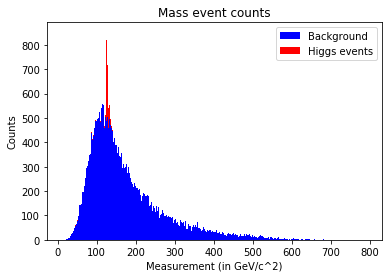

In [4]:
wt = np.ones(ram.get('mass').size)

plt.hist([ram.get('mass'), ranch.get('mass')], bins = 1000, weights=[(2000 / 2050) * wt, (50 / 2050) * wt], histtype='barstacked', color=['b', 'r'], label=['Background', 'Higgs events'])
# plt.hist(ram.get('mass'), bins = 1000, weights=50 / 2050, histtype='barstacked', color='b')
plt.xlabel('Measurement (in GeV/c^2)')
plt.ylabel('Counts')
plt.title('Mass event counts')
plt.legend()
plt.show()

In [9]:
print(50 / np.sqrt(2000))

1.118033988749895


Now we search for the cut that maximizes our expected significance. First, we are explicit with our procedure. Before we even attempt a cut, we note it better be centered at 125 GeV/c^2, as almost all of the Higgs events are centered about this region. Then, once we pick some cut, we find the fraction of events we have discarded both from the background, and from the Higgs events. This fraction will rescale our Poisson distributions in counts of the background and Higgs signals - specifically, if $\mu_i$ is the mean of one of the distributions before the cut, and $f_i$ is the fraction of events of type $i$ which survive the cut, then our new mean of our distribution will be $f_i \mu_i$. We then repeat our previous significance calculation; we will have a new mean on the background distribution after the cut, call it $\mu_b$, and a new mean on the Higgs events, $\mu_H$, so that we can find the expected significance by integrating a Poisson distribution of mean $\mu_b$ from 0 to $\mu_b + \mu_H$. From looking at our above stacked histogram, it is obvious we want to cut tightly about 125, and to make the search a little less intensive, we will demand the cut interval be roughly symmetric about this value, so we do not need to think about checking for possible optimizations that could be found by altering the asymmetry of the cut, even though this could be optimal. Instead, we examine our graphs from lab 5, and ballpark that a good proportion for the cut ought to favor keeping values on the right side of the peak, as the mass distribution is more likely to over than undershoot the Higgs mass.

In [20]:
tot = 100000
mig = 125.2
bmean = 2000
hmean = 50
sippy = [0, 0]
for i in range(1, 51):
    bs = 0
    hs = 0
    l = 0.05 * i
    hi = 0.5 * i
    for b in ram.get('mass'):
        if b >= mig - l and b <= mig + hi:
            bs += 1
    for h in ranch.get('mass'):
        if h >= mig - l and h <= mig + hi:
            hs += 1
    newB = (bs / tot) * bmean
    newH = (hs / tot) * hmean
    pee = jp.poisson.cdf(newB + newH, newB)
    siggy = jp.norm.ppf(pee)
#     print('For a cut interval from {} to {}, we find an expected significance of {} sigma.'.format(mig - (i * 0.5), mig + (0.5 * i), siggy))
    if siggy > sippy[0]:
        sippy = [siggy, l, hi, bs, hs]
#     print(bs, hs, pee)
print('The optimal significance is {} sigma at cut between {} and {}.'.format(sippy[0], mig - sippy[1], mig + sippy[2]))

The optimal significance is 4.194335457790806 sigma at cut between 124.75 and 129.7.


Again, we could refine this cut even more by looking at other cut windows in a closer neighborhood of the optimal cut window given above; however, the idea of looking for ever more optimal cuts by looking at a finer and finer neighborhood of a given cut is one that could continue ad nauseam, so we will not pursue this strategy. Instead, we will attempt to further optimize this expected significance by cutting on other parameters, too. Below, I will graph the stacked histograms of the mass coutns before and after the cut, and then I will move on to the other parameters.

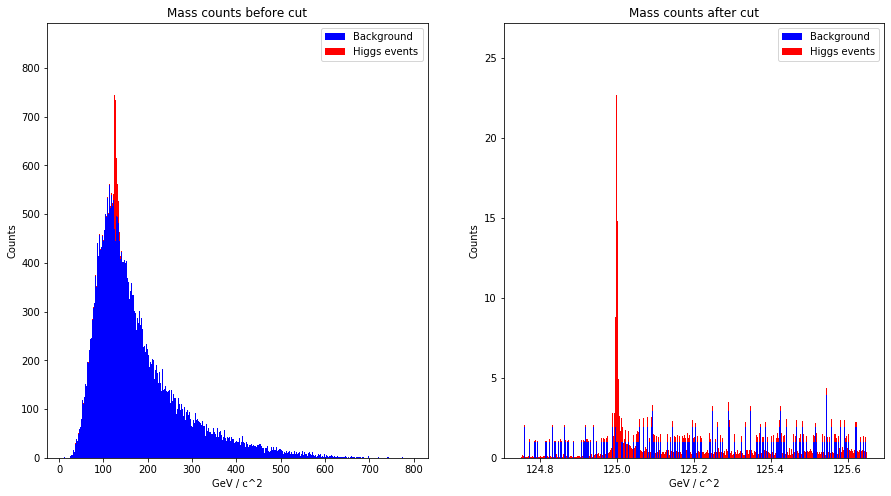

In [22]:
fig, a = plt.subplots(1, 2, figsize=(15, 8))
a[0].hist([ram.get('mass'), ranch.get('mass')], bins = 1000, weights=[(2000 / 2050) * wt, (50 / 2050) * wt], histtype='barstacked', color=['b', 'r'], label=['Background', 'Higgs events'])
awooga = np.where((ram.get('mass') >= mig - sippy[1]) & (ram.get('mass') <= mig + sippy[1]))
bowow = np.where((ranch.get('mass') >= mig - sippy[1]) & (ranch.get('mass') <= mig + sippy[1]))
ba = np.array(ram.get('mass'))[awooga]
hg = np.array(ranch.get('mass'))[bowow]
a[1].hist([ba, hg], bins = 1000, weights=[(2000 / 2050) * np.ones(ba.size), (50 / 2050) * np.ones(hg.size)], histtype='barstacked', color=['b', 'r'], label=['Background', 'Higgs events'])
a[0].set_title('Mass counts before cut')
a[0].set_xlabel('GeV / c^2')
a[0].set_ylabel('Counts')
a[0].legend()
a[1].set_title('Mass counts after cut')
a[1].set_xlabel('GeV / c^2')
a[1].set_ylabel('Counts')
a[1].legend()
plt.show()

We now go through parameters and generate stacked histograms to estimate where to cut, search through cut parameters as above to find some optimum, and then graph the resultant histogram after the cut. We show our stacked histograms after applying our optimal cut. Go parameter by parameter:

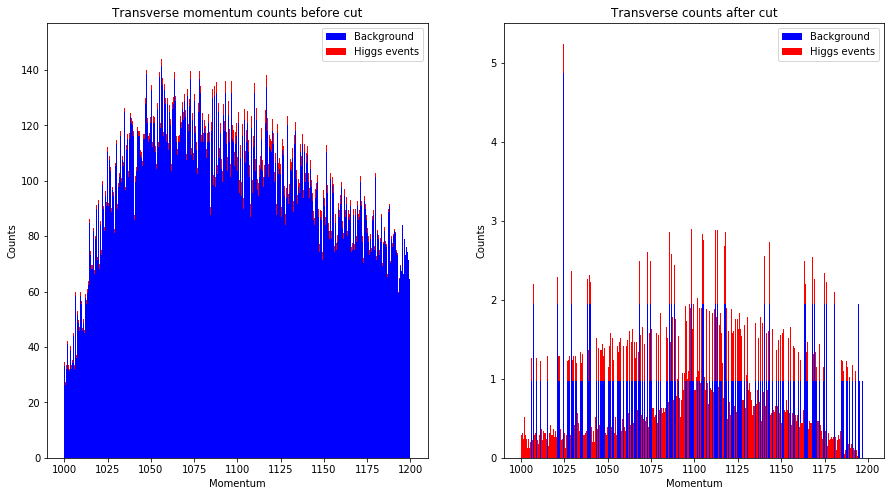

In [24]:
fig, a = plt.subplots(1, 2, figsize=(15, 8))
a[0].hist([ram.get('pt'), ranch.get('pt')], bins = 1000, weights=[(2000 / 2050) * wt, (50 / 2050) * wt], histtype='barstacked', color=['b', 'r'], label=['Background', 'Higgs events'])
a[1].hist([np.array(ram.get('pt'))[awooga], np.array(ranch.get('pt'))[bowow]], bins = 1000, weights=[(2000 / 2050) * np.ones(ba.size), (50 / 2050) * np.ones(hg.size)], histtype='barstacked', color=['b', 'r'], label=['Background', 'Higgs events'])
a[0].set_title('Transverse momentum counts before cut')
a[0].set_xlabel('Momentum')
a[0].set_ylabel('Counts')
a[0].legend()
a[1].set_title('Transverse momentum counts after cut')
a[1].set_xlabel('Momentum')
a[1].set_ylabel('Counts')
a[1].legend()
plt.show()

This is not an ideal discriminating feature, but the background appears approximately uniform random here while the Higgs events are lumped about the value 1100 or so -- however, this lumping is so weak that we cannot state for sure that it is happening -- there is no reason to believe that this is not also a trend with the background, but our mass cut was so effective that our counts of background events are now too low to see the clumping occur. So, this variable is not useful as a discriminator.

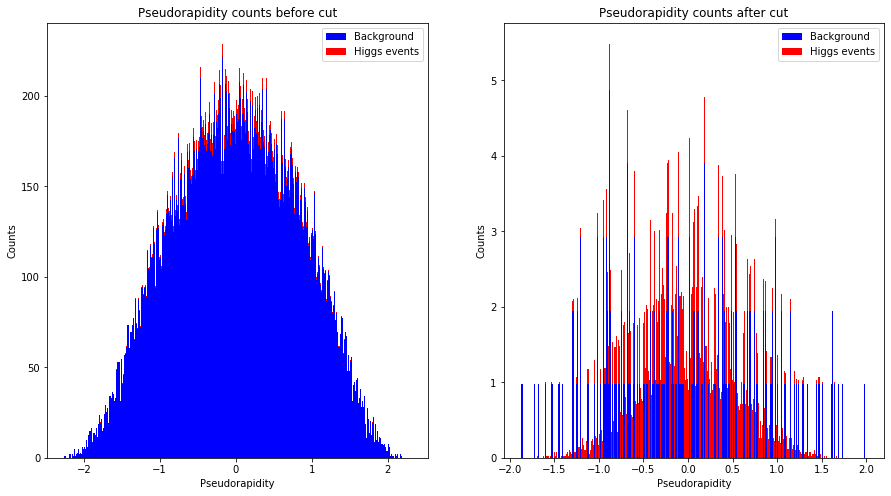

In [25]:
fig, a = plt.subplots(1, 2, figsize=(15, 8))
a[0].hist([ram.get('eta'), ranch.get('eta')], bins = 1000, weights=[(2000 / 2050) * wt, (50 / 2050) * wt], histtype='barstacked', color=['b', 'r'], label=['Background', 'Higgs events'])
a[1].hist([np.array(ram.get('eta'))[awooga], np.array(ranch.get('eta'))[bowow]], bins = 1000, weights=[(2000 / 2050) * np.ones(ba.size), (50 / 2050) * np.ones(hg.size)], histtype='barstacked', color=['b', 'r'], label=['Background', 'Higgs events'])
a[0].set_title('Pseudorapidity counts before cut')
a[0].set_xlabel('Pseudorapidity')
a[0].set_ylabel('Counts')
a[0].legend()
a[1].set_title('Pseudorapidity counts after cut')
a[1].set_xlabel('Pseudorapidity')
a[1].set_ylabel('Counts')
a[1].legend()
plt.show()

This variable displays much clearer clumping than in the case of transverse momentum, while still having the background appear to be more or less uniformly randomly distributed. This could be a useful discriminator.

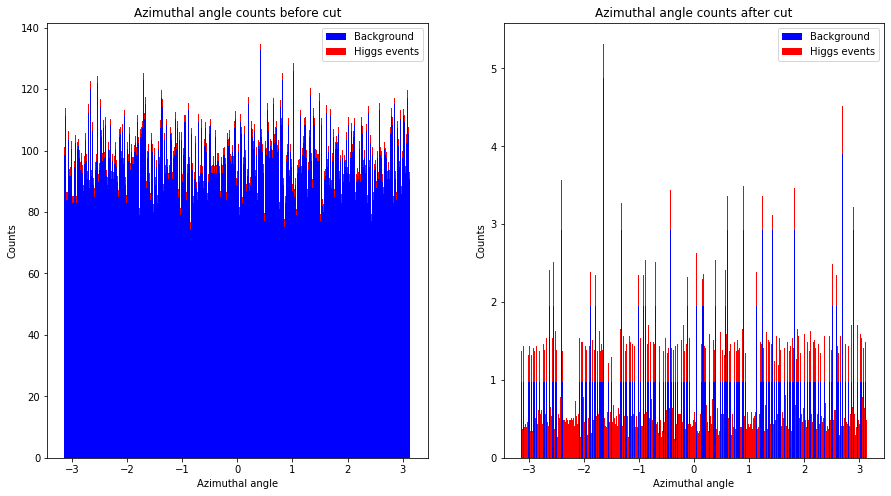

In [26]:
fig, a = plt.subplots(1, 2, figsize=(15, 8))
a[0].hist([ram.get('phi'), ranch.get('phi')], bins = 1000, weights=[(2000 / 2050) * wt, (50 / 2050) * wt], histtype='barstacked', color=['b', 'r'], label=['Background', 'Higgs events'])
a[1].hist([np.array(ram.get('phi'))[awooga], np.array(ranch.get('phi'))[bowow]], bins = 1000, weights=[(2000 / 2050) * np.ones(ba.size), (50 / 2050) * np.ones(hg.size)], histtype='barstacked', color=['b', 'r'], label=['Background', 'Higgs events'])
a[0].set_title('Azimuthal angle counts before cut')
a[0].set_xlabel('Azimuthal angle')
a[0].set_ylabel('Counts')
a[0].legend()
a[1].set_title('Azimuthal angle counts after cut')
a[1].set_xlabel('Azimuthal angle')
a[1].set_ylabel('Counts')
a[1].legend()
plt.show()

Both sets of data appear to be just noise in this variable. Considering what the graphs looked like on lab 5, I don't know what I expected.

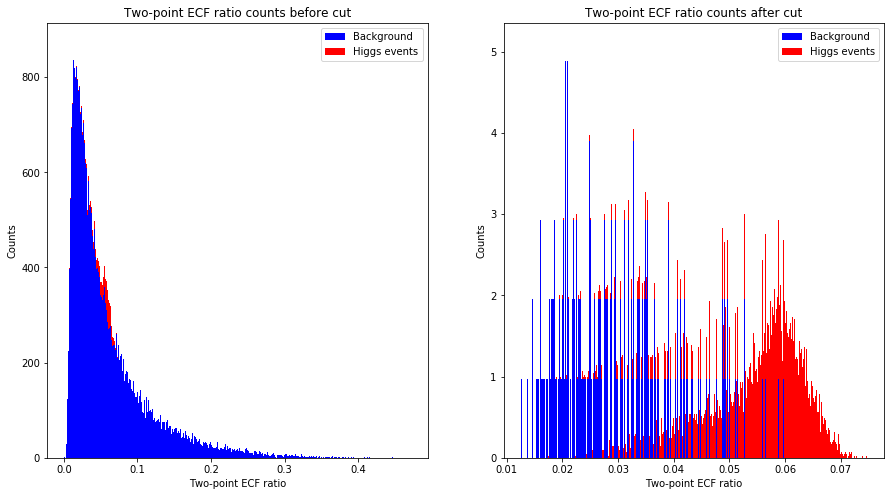

In [27]:
fig, a = plt.subplots(1, 2, figsize=(15, 8))
a[0].hist([ram.get('ee2'), ranch.get('ee2')], bins = 1000, weights=[(2000 / 2050) * wt, (50 / 2050) * wt], histtype='barstacked', color=['b', 'r'], label=['Background', 'Higgs events'])
a[1].hist([np.array(ram.get('ee2'))[awooga], np.array(ranch.get('ee2'))[bowow]], bins = 1000, weights=[(2000 / 2050) * np.ones(ba.size), (50 / 2050) * np.ones(hg.size)], histtype='barstacked', color=['b', 'r'], label=['Background', 'Higgs events'])
a[0].set_title('Two-point ECF ratio counts before cut')
a[0].set_xlabel('Two-point ECF ratio')
a[0].set_ylabel('Counts')
a[0].legend()
a[1].set_title('Two-point ECF ratio counts after cut')
a[1].set_xlabel('Two-point ECF ratio')
a[1].set_ylabel('Counts')
a[1].legend()
plt.show()

This looks to be a $\textit{very}$ powerful discriminator; the Higgs events' mean is far from almost all of the background events! A suitable cut could easily purge background events until they are in the double or even single digits, if we start our cut at approximately 0.06 and extend it above to at least 0.07.

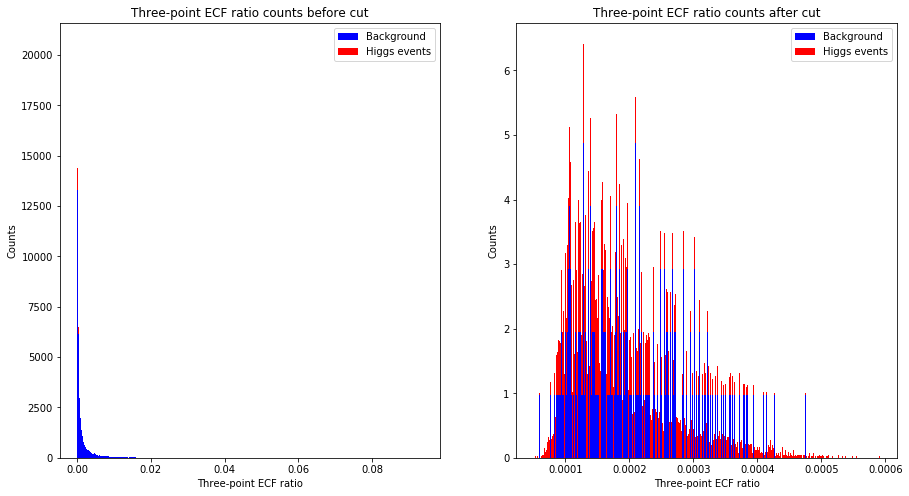

In [28]:
fig, a = plt.subplots(1, 2, figsize=(15, 8))
a[0].hist([ram.get('ee3'), ranch.get('ee3')], bins = 1000, weights=[(2000 / 2050) * wt, (50 / 2050) * wt], histtype='barstacked', color=['b', 'r'], label=['Background', 'Higgs events'])
a[1].hist([np.array(ram.get('ee3'))[awooga], np.array(ranch.get('ee3'))[bowow]], bins = 1000, weights=[(2000 / 2050) * np.ones(ba.size), (50 / 2050) * np.ones(hg.size)], histtype='barstacked', color=['b', 'r'], label=['Background', 'Higgs events'])
a[0].set_title('Three-point ECF ratio counts before cut')
a[0].set_xlabel('Three-point ECF ratio')
a[0].set_ylabel('Counts')
a[0].legend()
a[1].set_title('Three-point ECF ratio counts after cut')
a[1].set_xlabel('Three-point ECF ratio')
a[1].set_ylabel('Counts')
a[1].legend()
plt.show()

Nowhere near as good as the ee2 graph. The background and Higgs events seem clustered about the same value. Cutting on this could have some utility, but why bother when ee2 looks so promising?

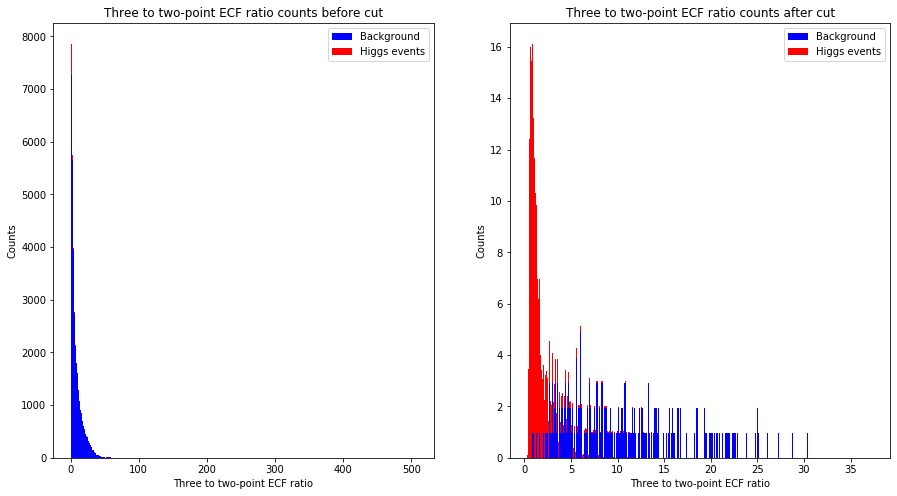

In [29]:
fig, a = plt.subplots(1, 2, figsize=(15, 8))
a[0].hist([ram.get('d2'), ranch.get('d2')], bins = 1000, weights=[(2000 / 2050) * wt, (50 / 2050) * wt], histtype='barstacked', color=['b', 'r'], label=['Background', 'Higgs events'])
a[1].hist([np.array(ram.get('d2'))[awooga], np.array(ranch.get('d2'))[bowow]], bins = 1000, weights=[(2000 / 2050) * np.ones(ba.size), (50 / 2050) * np.ones(hg.size)], histtype='barstacked', color=['b', 'r'], label=['Background', 'Higgs events'])
a[0].set_title('Three to two-point ECF ratio counts before cut')
a[0].set_xlabel('Three to two-point ECF ratio')
a[0].set_ylabel('Counts')
a[0].legend()
a[1].set_title('Three to two-point ECF ratio counts after cut')
a[1].set_xlabel('Three to two-point ECF ratio')
a[1].set_ylabel('Counts')
a[1].legend()
plt.show()

Now this is a clean discriminator. The background and Higgs events have very little overlap, meaning a cut selecting out only events will a small value for this parameter will keep very few background events. This will also be used in our optimal, final list of cuts.

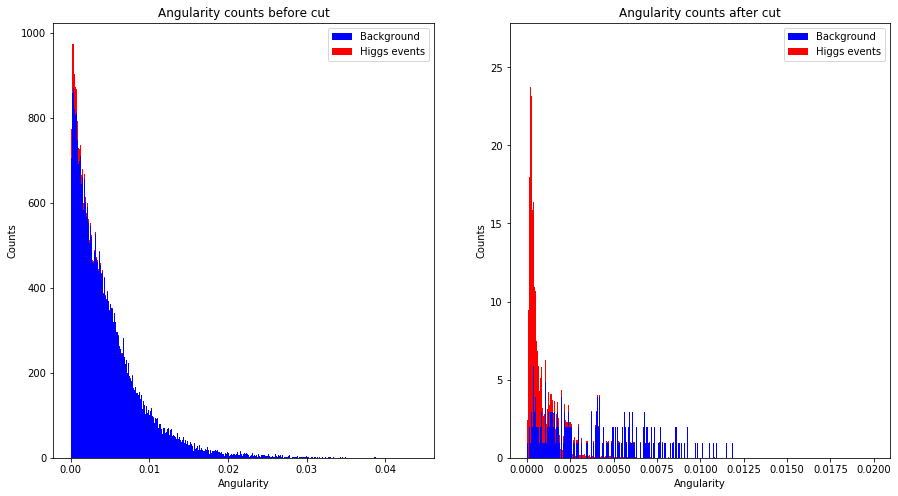

In [30]:
fig, a = plt.subplots(1, 2, figsize=(15, 8))
a[0].hist([ram.get('angularity'), ranch.get('angularity')], bins = 1000, weights=[(2000 / 2050) * wt, (50 / 2050) * wt], histtype='barstacked', color=['b', 'r'], label=['Background', 'Higgs events'])
a[1].hist([np.array(ram.get('angularity'))[awooga], np.array(ranch.get('angularity'))[bowow]], bins = 1000, weights=[(2000 / 2050) * np.ones(ba.size), (50 / 2050) * np.ones(hg.size)], histtype='barstacked', color=['b', 'r'], label=['Background', 'Higgs events'])
a[0].set_title('Angularity counts before cut')
a[0].set_xlabel('Angularity')
a[0].set_ylabel('Counts')
a[0].legend()
a[1].set_title('Angularity counts after cut')
a[1].set_xlabel('Angularity')
a[1].set_ylabel('Counts')
a[1].legend()
plt.show()

Not a terrible feature to use for a cut, but nowhere near as good as the other two parameters. Though the Higgs events are nicely clustered here, they occupy the same region of the graph as a large number of background events, so a cut would not be anywhere near as clean as the other two graphs for ee2 and d2, which had the Higgs events clustered about a region with very little background noise contamination.

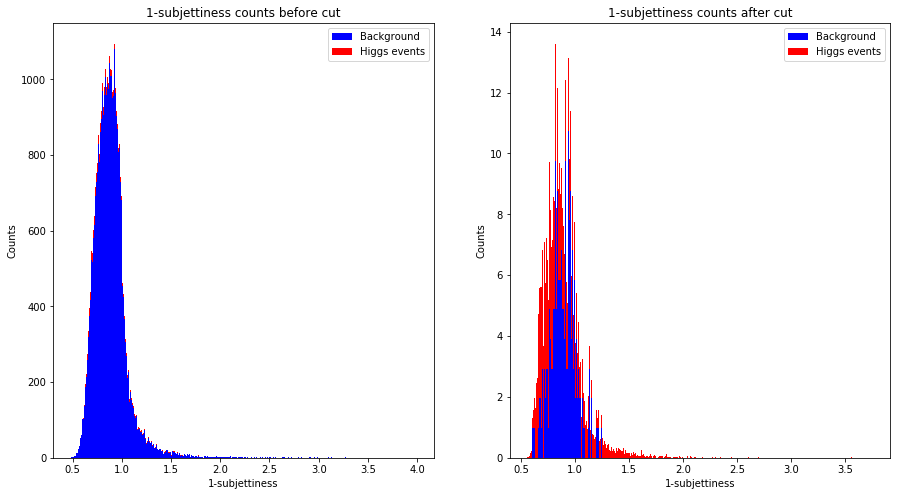

In [31]:
fig, a = plt.subplots(1, 2, figsize=(15, 8))
a[0].hist([ram.get('t1'), ranch.get('t1')], bins = 1000, weights=[(2000 / 2050) * wt, (50 / 2050) * wt], histtype='barstacked', color=['b', 'r'], label=['Background', 'Higgs events'])
a[1].hist([np.array(ram.get('t1'))[awooga], np.array(ranch.get('t1'))[bowow]], bins = 1000, weights=[(2000 / 2050) * np.ones(ba.size), (50 / 2050) * np.ones(hg.size)], histtype='barstacked', color=['b', 'r'], label=['Background', 'Higgs events'])
a[0].set_title('1-subjettiness counts before cut')
a[0].set_xlabel('1-subjettiness')
a[0].set_ylabel('Counts')
a[0].legend()
a[1].set_title('1-subjettiness counts after cut')
a[1].set_xlabel('1-subjettiness')
a[1].set_ylabel('Counts')
a[1].legend()
plt.show()

Not very good at all. There is still too much overlap on of the values after the cut, so this would not be useful for determining another cut.

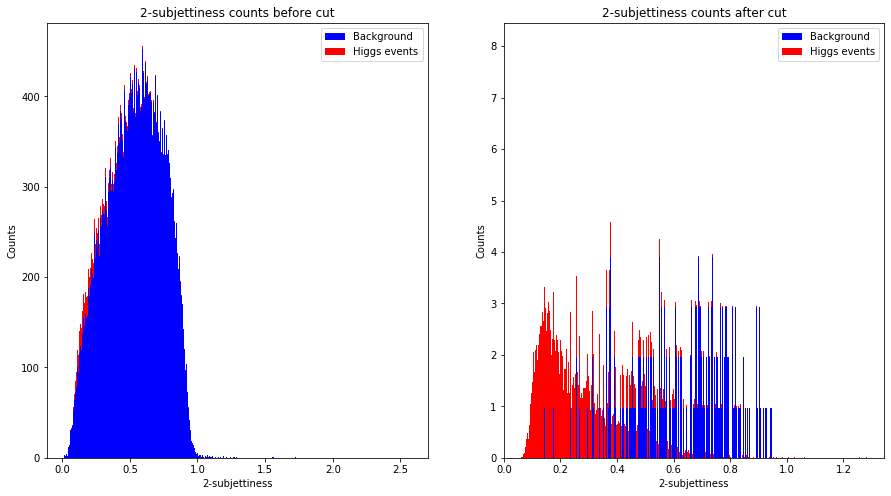

In [32]:
fig, a = plt.subplots(1, 2, figsize=(15, 8))
a[0].hist([ram.get('t2'), ranch.get('t2')], bins = 1000, weights=[(2000 / 2050) * wt, (50 / 2050) * wt], histtype='barstacked', color=['b', 'r'], label=['Background', 'Higgs events'])
a[1].hist([np.array(ram.get('t2'))[awooga], np.array(ranch.get('t2'))[bowow]], bins = 1000, weights=[(2000 / 2050) * np.ones(ba.size), (50 / 2050) * np.ones(hg.size)], histtype='barstacked', color=['b', 'r'], label=['Background', 'Higgs events'])
a[0].set_title('2-subjettiness counts before cut')
a[0].set_xlabel('2-subjettiness')
a[0].set_ylabel('Counts')
a[0].legend()
a[1].set_title('2-subjettiness counts after cut')
a[1].set_xlabel('2-subjettiness')
a[1].set_ylabel('Counts')
a[1].legend()
plt.show()

This is promising. A cut selecting low values of 2-subjettiness appears to have minimal noise for suitably small values in the cut. Flagged for further use along with ee2 and d2.

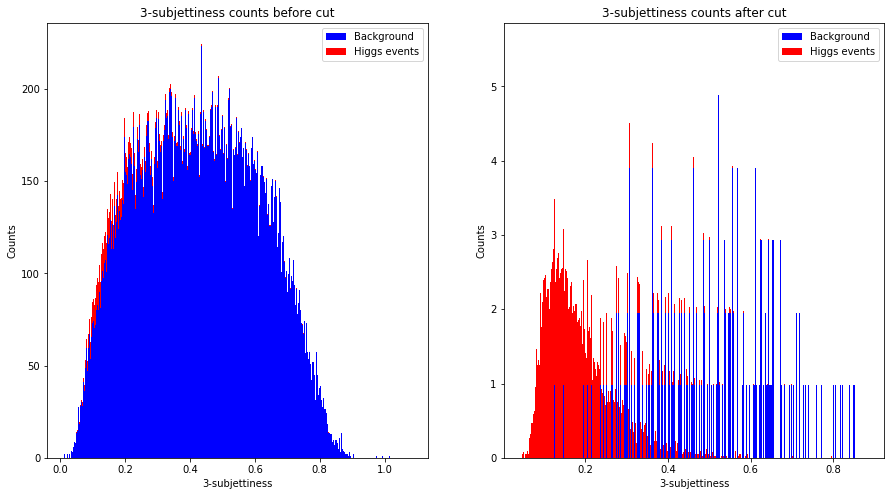

In [33]:
fig, a = plt.subplots(1, 2, figsize=(15, 8))
a[0].hist([ram.get('t3'), ranch.get('t3')], bins = 1000, weights=[(2000 / 2050) * wt, (50 / 2050) * wt], histtype='barstacked', color=['b', 'r'], label=['Background', 'Higgs events'])
a[1].hist([np.array(ram.get('t3'))[awooga], np.array(ranch.get('t3'))[bowow]], bins = 1000, weights=[(2000 / 2050) * np.ones(ba.size), (50 / 2050) * np.ones(hg.size)], histtype='barstacked', color=['b', 'r'], label=['Background', 'Higgs events'])
a[0].set_title('3-subjettiness counts before cut')
a[0].set_xlabel('3-subjettiness')
a[0].set_ylabel('Counts')
a[0].legend()
a[1].set_title('3-subjettiness counts after cut')
a[1].set_xlabel('3-subjettiness')
a[1].set_ylabel('Counts')
a[1].legend()
plt.show()

Even better than 2-subjettiness! Flagged for use as a cutting parameter, for the same reasons as t2.

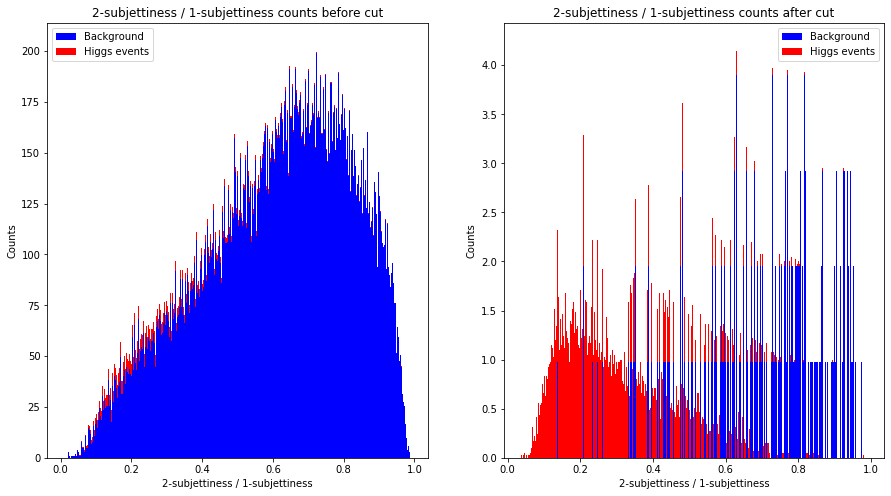

In [34]:
fig, a = plt.subplots(1, 2, figsize=(15, 8))
a[0].hist([ram.get('t21'), ranch.get('t21')], bins = 1000, weights=[(2000 / 2050) * wt, (50 / 2050) * wt], histtype='barstacked', color=['b', 'r'], label=['Background', 'Higgs events'])
a[1].hist([np.array(ram.get('t21'))[awooga], np.array(ranch.get('t21'))[bowow]], bins = 1000, weights=[(2000 / 2050) * np.ones(ba.size), (50 / 2050) * np.ones(hg.size)], histtype='barstacked', color=['b', 'r'], label=['Background', 'Higgs events'])
a[0].set_title('2-subjettiness / 1-subjettiness counts before cut')
a[0].set_xlabel('2-subjettiness / 1-subjettiness')
a[0].set_ylabel('Counts')
a[0].legend()
a[1].set_title('2-subjettiness / 1-subjettiness counts after cut')
a[1].set_xlabel('2-subjettiness / 1-subjettiness')
a[1].set_ylabel('Counts')
a[1].legend()
plt.show()

It is in fact a good parameter to look at. Consider with t2 and t3.

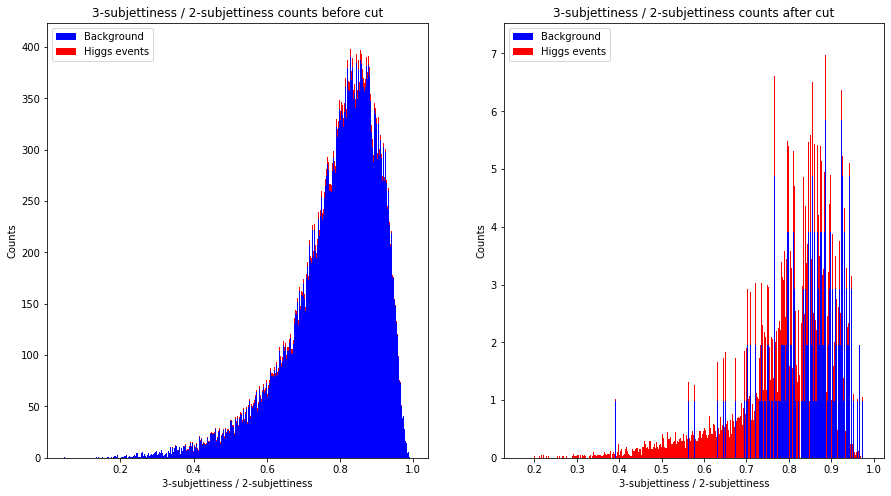

In [35]:
fig, a = plt.subplots(1, 2, figsize=(15, 8))
a[0].hist([ram.get('t32'), ranch.get('t32')], bins = 1000, weights=[(2000 / 2050) * wt, (50 / 2050) * wt], histtype='barstacked', color=['b', 'r'], label=['Background', 'Higgs events'])
a[1].hist([np.array(ram.get('t32'))[awooga], np.array(ranch.get('t32'))[bowow]], bins = 1000, weights=[(2000 / 2050) * np.ones(ba.size), (50 / 2050) * np.ones(hg.size)], histtype='barstacked', color=['b', 'r'], label=['Background', 'Higgs events'])
a[0].set_title('3-subjettiness / 2-subjettiness counts before cut')
a[0].set_xlabel('3-subjettiness / 2-subjettiness')
a[0].set_ylabel('Counts')
a[0].legend()
a[1].set_title('3-subjettiness / 2-subjettiness counts after cut')
a[1].set_xlabel('3-subjettiness / 2-subjettiness')
a[1].set_ylabel('Counts')
a[1].legend()
plt.show()

The tail of the Higgs distribution here appears largely noise free, so it may be worth cutting along it. It is not as good as the other parameters, though; the tail is lower statistics in the Higgs.

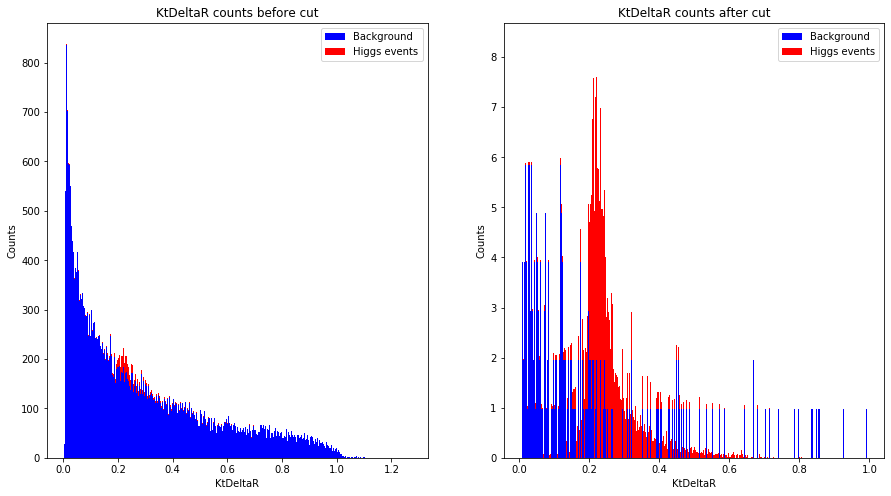

In [36]:
fig, a = plt.subplots(1, 2, figsize=(15, 8))
a[0].hist([ram.get('KtDeltaR'), ranch.get('KtDeltaR')], bins = 1000, weights=[(2000 / 2050) * wt, (50 / 2050) * wt], histtype='barstacked', color=['b', 'r'], label=['Background', 'Higgs events'])
a[1].hist([np.array(ram.get('KtDeltaR'))[awooga], np.array(ranch.get('KtDeltaR'))[bowow]], bins = 1000, weights=[(2000 / 2050) * np.ones(ba.size), (50 / 2050) * np.ones(hg.size)], histtype='barstacked', color=['b', 'r'], label=['Background', 'Higgs events'])
a[0].set_title('KtDeltaR counts before cut')
a[0].set_xlabel('KtDeltaR')
a[0].set_ylabel('Counts')
a[0].legend()
a[1].set_title('KtDeltaR counts after cut')
a[1].set_xlabel('KtDeltaR')
a[1].set_ylabel('Counts')
a[1].legend()
plt.show()

This is not a terrible choice to cut off of, but again, it has more noise contamination than some of our other options. We will use it, but it is among the noiser 'cuttable' parameters.

# Making the next cuts

Now, begin our cuts. There is the question of whether we determine each cut independently of the others, or if we make one cut, and then determine them sequentially, each cut being applied before we make the next cut. I choose the latter, but observe there is a problem in this method -- conceivably, the order in which we determine cuts matters, as making one cut first could make the next very clean and remove noise that makes the cut harder to determine. To get the ideal cut, we ought to try every permutation of determining the cuts when using this method. However, I will not do this, simply because there are 7 potential parameters we have flagged to use for cuts, and considering it takes my little laptop a nonzero amount of time to find a single cut, trying all 7! orders of determining the cuts would be a bit absurd. I will acknowledge that I am sweeping a nuanced issue under the rug here, but I am still sweeping it. I instead will simply determine cuts in the subjective order of decresing 'messiness' of the parameter, that is, I will cut more noise paramters first, in the hopes that this will make the cleaner paramters easy to cut. The first few paramters, we will cut a little more generously, knowing that later paramters can be cut strictly if needed to pick up the slack.  




ee2 d2 t2 t3 t21 t32 ktdeltar

# Cut: KtDeltaR

In [74]:
kit = 0.24
totb = np.array(ram.get('mass'))[awooga].size
toth = np.array(ranch.get('mass'))[bowow].size
bmean = 2000 * (totb / tot)
hmean = 50 * (toth / tot)
owo = [0, 0]
for i in range(1, 101):
    bs = 0
    hs = 0
    l = 0.007 * i
    hi = 0.02 * i
    for b in np.array(ram.get('KtDeltaR'))[awooga]:
        if b >= kit - l and b <= kit + hi:
            bs += 1
    for h in np.array(ranch.get('KtDeltaR'))[bowow]:
        if h >= kit - l and h <= kit + hi:
            hs += 1
    newB = (bs / totb) * bmean
    newH = (hs / toth) * hmean
    pee = jp.poisson.cdf(newB + newH, newB)
    siggy = jp.norm.ppf(pee)
#     print('For a cut interval from {} to {}, we find an expected significance of {} sigma.'.format(kit - l, kit + hi, siggy))
    if siggy >= owo[0]:
        owo = [siggy, l, hi, bs, hs]
#     print(bs, hs, pee, l, hi)
print('The optimal significance is {} sigma at cut between {} and {}.'.format(owo[0], kit - owo[1], kit + owo[2]))
# print(totb, toth, owo)

# Perform the cut; find a new set of indices
juan = np.array(ram.get('KtDeltaR'))[awooga]
julio = np.array(ranch.get('KtDeltaR'))[bowow]
yabadaba = np.where((juan >= kit - owo[1]) & (juan <= kit + owo[2]))
doo = np.where((julio >= kit - owo[1]) & (julio <= kit + owo[2]))

The optimal significance is 4.431070543250215 sigma at cut between 0.191 and 0.38.


# Cut: ee2

In [72]:
bd = 0.07
totb = juan[yabadaba].size
toth = julio[doo].size
# print(toth, totb)
bmean = 2000 * (totb / tot)
hmean = 50 * (toth / tot)
owo = [0, 0]
for i in range(1, 401):
    bs = 0
    hs = 0
    lo = i * 0.0001
    for b in np.array(ram.get('ee2'))[yabadaba]:
        if b >= bd - lo:
            bs += 1
    for h in np.array(ranch.get('ee2'))[doo]:
        if h >= bd - lo:
            hs += 1
    newB = (bs / totb) * bmean
    newH = (hs / toth) * hmean
    pee = jp.poisson.cdf(newB + newH, newB)
    siggy = jp.norm.ppf(pee)
#     print('For a cut interval from {} to {}, we find an expected significance of {} sigma.'.format(kit - l, kit + hi, siggy))
    if siggy >= owo[0]:
        owo = [siggy, lo, bs, hs]
#     print(bs, hs, pee)
print('The optimal significance is {} sigma by cutting all values less than {}.'.format(owo[0], bd - owo[1]))

# Perform the cut and get a new index set
glaucoma = np.array(ram.get('ee2'))[yabadaba]
girdle = np.array(ranch.get('ee2'))[doo]
eiei = np.where(glaucoma >= bd - owo[1])
oh = np.where(girdle >= bd - owo[1])

The optimal significance is 4.762718926391531 sigma by cutting all values less than 0.0386.


# Cut: d2

In [85]:
totb = glaucoma[eiei].size
toth = girdle[oh].size
bmean = 2000 * (totb / tot)
hmean = 50 * (toth / tot)
owo = [0, 0]
for i in range(1, 401):
    bs = 0
    hs = 0
    lo = i * 0.01
    for b in np.array(ram.get('d2'))[eiei]:
        if b <= lo:
            bs += 1
    for h in np.array(ranch.get('d2'))[oh]:
        if h <= lo:
            hs += 1
    newB = (bs / totb) * bmean
    newH = (hs / toth) * hmean
    pee = jp.poisson.cdf(newB + newH, newB)
    siggy = jp.norm.ppf(pee)
#     print('For a cut interval from {} to {}, we find an expected significance of {} sigma.'.format(kit - l, kit + hi, siggy))
    if siggy >= owo[0]:
        owo = [siggy, lo, bs, hs]
    print(owo, siggy, bs)
print('The optimal significance is {} sigma by cutting all values less than {}.'.format(owo[0], owo[1]))
# print(owo)

[inf, 0.01, 0, 0] inf 0
[inf, 0.02, 0, 0] inf 0
[inf, 0.03, 0, 0] inf 0
[inf, 0.04, 0, 0] inf 0
[inf, 0.05, 0, 0] inf 0
[inf, 0.06, 0, 0] inf 0
[inf, 0.07, 0, 0] inf 0
[inf, 0.08, 0, 0] inf 0
[inf, 0.09, 0, 0] inf 0
[inf, 0.1, 0, 0] inf 0
[inf, 0.11, 0, 0] inf 0
[inf, 0.12, 0, 0] inf 0
[inf, 0.13, 0, 0] inf 0
[inf, 0.14, 0, 0] inf 0
[inf, 0.15, 0, 0] inf 0
[inf, 0.16, 0, 0] inf 0
[inf, 0.17, 0, 0] inf 0
[inf, 0.18, 0, 0] inf 0
[inf, 0.19, 0, 0] inf 0
[inf, 0.2, 0, 0] inf 0
[inf, 0.21, 0, 0] inf 0
[inf, 0.22, 0, 0] inf 0
[inf, 0.23, 0, 0] inf 0
[inf, 0.24, 0, 0] inf 0
[inf, 0.25, 0, 0] inf 0
[inf, 0.26, 0, 0] inf 0
[inf, 0.27, 0, 0] inf 0
[inf, 0.28, 0, 0] inf 0
[inf, 0.29, 0, 0] inf 0
[inf, 0.3, 0, 0] inf 0
[inf, 0.31, 0, 0] inf 0
[inf, 0.32, 0, 0] inf 0
[inf, 0.33, 0, 0] inf 0
[inf, 0.34, 0, 0] inf 0
[inf, 0.35000000000000003, 0, 1] inf 0
[inf, 0.36, 0, 1] inf 0
[inf, 0.37, 0, 3] inf 0
[inf, 0.38, 0, 6] inf 0
[inf, 0.39, 0, 9] inf 0
[inf, 0.4, 0, 15] inf 0
[inf, 0.41000000000000003, 0

[inf, 0.8300000000000001, 0, 2834] 5.149690924187728 11
[inf, 0.8300000000000001, 0, 2834] 5.149690924187728 11
[inf, 0.8300000000000001, 0, 2834] 5.149690924187728 11
[inf, 0.8300000000000001, 0, 2834] 5.149690924187728 11
[inf, 0.8300000000000001, 0, 2834] 5.149690924187728 11
[inf, 0.8300000000000001, 0, 2834] 5.149690924187728 11
[inf, 0.8300000000000001, 0, 2834] 5.149690924187728 11
[inf, 0.8300000000000001, 0, 2834] 5.054140670130792 12
[inf, 0.8300000000000001, 0, 2834] 5.054140670130792 12
[inf, 0.8300000000000001, 0, 2834] 4.964992732924721 13
[inf, 0.8300000000000001, 0, 2834] 4.964992732924721 13
[inf, 0.8300000000000001, 0, 2834] 4.964992732924721 13
[inf, 0.8300000000000001, 0, 2834] 4.964992732924721 13
[inf, 0.8300000000000001, 0, 2834] 4.964992732924721 13
[inf, 0.8300000000000001, 0, 2834] 4.964992732924721 13
[inf, 0.8300000000000001, 0, 2834] 4.964992732924721 13
[inf, 0.8300000000000001, 0, 2834] 4.964992732924721 13
[inf, 0.8300000000000001, 0, 2834] 4.96499273292

[inf, 0.8300000000000001, 0, 2834] 4.862708486325646 23
[inf, 0.8300000000000001, 0, 2834] 4.862708486325646 23
[inf, 0.8300000000000001, 0, 2834] 4.862708486325646 23
[inf, 0.8300000000000001, 0, 2834] 4.862708486325646 23
[inf, 0.8300000000000001, 0, 2834] 4.862708486325646 23
[inf, 0.8300000000000001, 0, 2834] 4.862708486325646 23
[inf, 0.8300000000000001, 0, 2834] 4.862708486325646 23
[inf, 0.8300000000000001, 0, 2834] 4.862708486325646 23
[inf, 0.8300000000000001, 0, 2834] 4.862708486325646 23
[inf, 0.8300000000000001, 0, 2834] 4.862708486325646 23
[inf, 0.8300000000000001, 0, 2834] 4.862708486325646 23
[inf, 0.8300000000000001, 0, 2834] 4.862708486325646 23
[inf, 0.8300000000000001, 0, 2834] 4.862708486325646 23
[inf, 0.8300000000000001, 0, 2834] 4.862708486325646 23
[inf, 0.8300000000000001, 0, 2834] 4.862708486325646 23
[inf, 0.8300000000000001, 0, 2834] 4.862708486325646 23
[inf, 0.8300000000000001, 0, 2834] 4.862708486325646 23
[inf, 0.8300000000000001, 0, 2834] 4.86270848632